In [1]:
# VENDAS - PREVISÃO COM MODELOS SELECIONADOS + RF/XGB (36 meses)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoETS, AutoARIMA, Naive

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
# 1. Carregar dados
df = pd.read_csv(r"resumo_vendas_regiao 1.csv")

df = df.rename(columns={"data": "ds", "vendas": "y"})
df['ds'] = pd.to_datetime(df['ds'])

# Agrupar por mês
df_grouped = df.groupby(df['ds'].dt.to_period('M'))['y'].sum().reset_index()
df_grouped['ds'] = df_grouped['ds'].dt.to_timestamp()

# Ajustar colunas para StatsForecast
df_grouped['unique_id'] = 'serie1'
df_grouped = df_grouped[['unique_id', 'ds', 'y']]

print(df_grouped.head())


  unique_id         ds            y
0    serie1 2021-01-01   3632707.42
1    serie1 2021-02-01  12812183.31
2    serie1 2021-03-01  21306031.44
3    serie1 2021-04-01   2329599.24
4    serie1 2021-05-01   9424709.03


In [3]:
# 2. Definir modelos (StatsForecast)
sf = StatsForecast(
    models=[
        AutoETS(season_length=12),
        AutoARIMA(season_length=12),
        Naive()
    ],
    freq='ME',
    n_jobs=-1
)


In [12]:
# 3. Cross-validation (backtest) - 12 meses
cv_results = sf.cross_validation(
    df=df_grouped,
    h=12,
    step_size=12,
    n_windows=3
)

print(cv_results.head())


                  ds     cutoff           y     AutoETS   AutoARIMA  \
unique_id                                                             
serie1    2022-09-01 2022-08-01   6855019.5  10410530.0  10113390.0   
serie1    2022-10-01 2022-08-01  15056373.0  10410530.0  10113388.0   
serie1    2022-11-01 2022-08-01   9206098.0  10410530.0  10113386.0   
serie1    2022-12-01 2022-08-01  12771209.0  10410530.0  10113384.0   
serie1    2023-01-01 2022-08-01  19653944.0  10410530.0  10113382.0   

                Naive  
unique_id              
serie1     11548621.0  
serie1     11548621.0  
serie1     11548621.0  
serie1     11548621.0  
serie1     11548621.0  


C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [5]:
# 4. Função de métricas
def calc_metrics(df, model):
    df_eval = df.dropna(subset=['y', model])
    y_true = df_eval['y'].values
    y_pred = df_eval[model].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}


In [6]:
# 5. Avaliar modelos do StatsForecast
models_to_eval = ['AutoETS', 'AutoARIMA', 'Naive']
metrics = {m: calc_metrics(cv_results, m) for m in models_to_eval}


In [22]:
# 6. Random Forest e XGBoost (últimos 12 meses)

df_ml = df_grouped.copy()
df_ml['year'] = df_ml['ds'].dt.year
df_ml['month'] = df_ml['ds'].dt.month

# Criar lags
df_ml['lag1'] = df_ml['y'].shift(1)
df_ml['lag2'] = df_ml['y'].shift(2)
df_ml['lag3'] = df_ml['y'].shift(3)
df_ml = df_ml.dropna()

X = df_ml[['year', 'month', 'lag1', 'lag2', 'lag3']]
y = df_ml['y']

# Últimos 12 meses como teste
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

def calc_metrics_array(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

metrics['RandomForest'] = calc_metrics_array(y_test, y_pred_rf)
metrics['XGBoost'] = calc_metrics_array(y_test, y_pred_xgb)

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                      RMSE           MAE       MAPE        R2
AutoETS       7.913275e+06  4.843474e+06  49.928596 -0.029795
AutoARIMA     8.433191e+06  5.064096e+06  48.082291 -0.169559
Naive         8.574642e+06  5.409842e+06  55.788254 -0.209122
RandomForest  9.627055e+06  6.631916e+06  49.843557  0.271395
XGBoost       1.121372e+07  6.533703e+06  41.632861  0.011438


In [8]:
# 7. Escolher melhor modelo pelo RMSE
best_model = metrics_df['RMSE'].idxmin()
print("📌 Melhor modelo:", best_model)
print(metrics_df.loc[best_model])


📌 Melhor modelo: AutoETS
RMSE    7.913275e+06
MAE     4.843474e+06
MAPE    4.992860e+01
R2     -2.979469e-02
Name: AutoETS, dtype: float64


In [9]:
# 8. Previsão final para 36 meses (StatsForecast)
sf.fit(df_grouped)
forecast_36 = sf.predict(h=36)
print(forecast_36.head())


                  ds     AutoETS   AutoARIMA       Naive
unique_id                                               
serie1    2025-08-31   5921025.5   6871632.5  11082438.0
serie1    2025-09-30  11045042.0   9392773.0  11082438.0
serie1    2025-10-31  13418504.0  15200856.0  11082438.0
serie1    2025-11-30   9136039.0   9059005.0  11082438.0
serie1    2025-12-31  14394217.0  15553179.0  11082438.0


C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [24]:
from pandas.tseries.offsets import MonthEnd

# Vamos usar os últimos dados como base
future_dates = pd.date_range(df_ml['ds'].max() + MonthEnd(1), periods=36, freq='M')

# Copiar dataset para expandir
df_future = df_ml.copy()

preds_rf, preds_xgb = [], []

last_known = df_ml.copy()

for date in future_dates:
    # features temporais
    year = date.year
    month = date.month
    
    # pegar últimos lags
    lag1 = last_known['y'].iloc[-1]
    lag2 = last_known['y'].iloc[-2]
    lag3 = last_known['y'].iloc[-3]
    
    X_future = pd.DataFrame([[year, month, lag1, lag2, lag3]],
                            columns=['year','month','lag1','lag2','lag3'])
    
    # previsões
    y_hat_rf = rf.predict(X_future)[0]
    y_hat_xgb = xgb.predict(X_future)[0]
    
    # salvar
    preds_rf.append(y_hat_rf)
    preds_xgb.append(y_hat_xgb)
    
    # adicionar ao histórico (para atualizar lags)
    new_row = pd.DataFrame([[ 'serie1', date, y_hat_rf ]],
                           columns=['unique_id','ds','y'])
    last_known = pd.concat([last_known, new_row], ignore_index=True)

# DataFrames finais de previsões
forecast_rf = pd.DataFrame({'ds': future_dates, 'RandomForest': preds_rf})
forecast_xgb = pd.DataFrame({'ds': future_dates, 'XGBoost': preds_xgb})

print(forecast_rf.head())
print(forecast_xgb.head())


C:\Users\Edmundo Simeon\AppData\Local\Temp\ipykernel_37608\3804539156.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(df_ml['ds'].max() + MonthEnd(1), periods=36, freq='M')


          ds  RandomForest
0 2025-08-31  7.496664e+06
1 2025-09-30  1.034683e+07
2 2025-10-31  8.066638e+06
3 2025-11-30  1.153765e+07
4 2025-12-31  9.454987e+06
          ds     XGBoost
0 2025-08-31   7683377.0
1 2025-09-30   8224882.5
2 2025-10-31   7297541.0
3 2025-11-30  11164606.0
4 2025-12-31   7893843.0


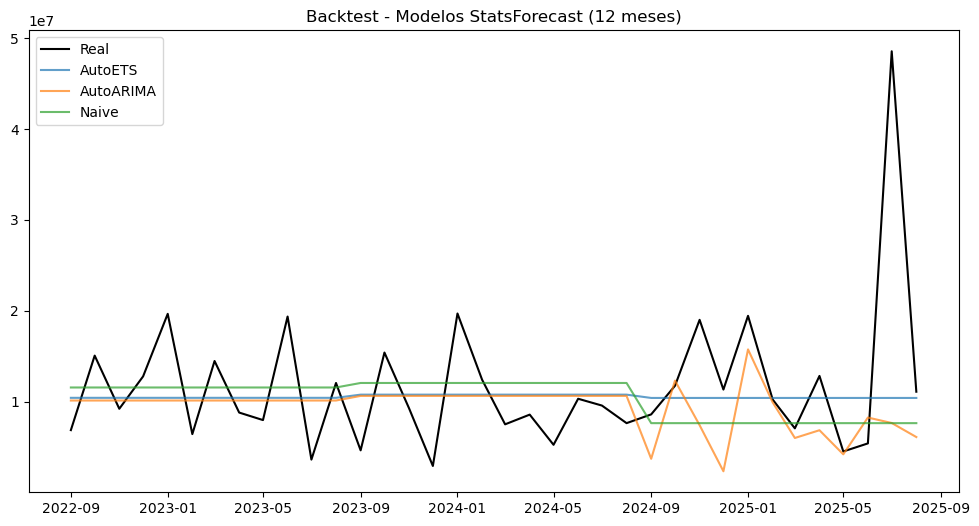

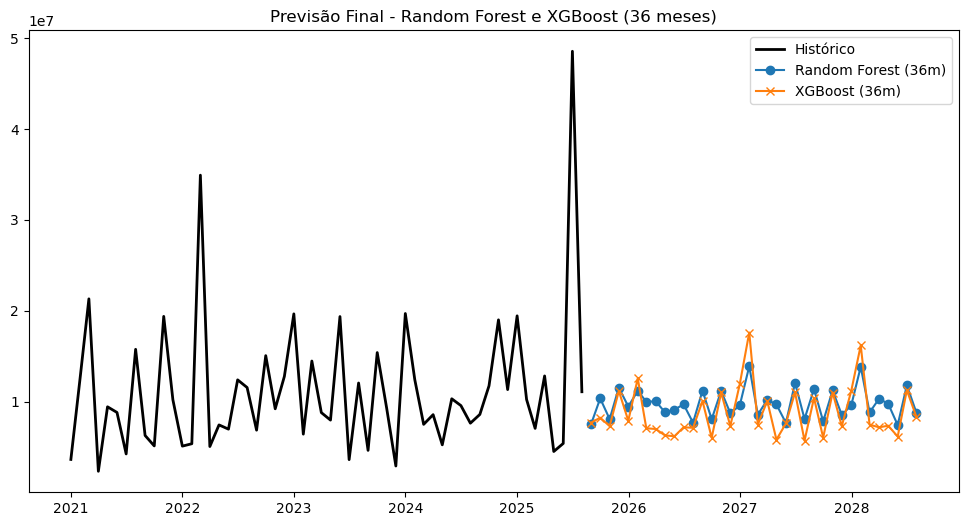

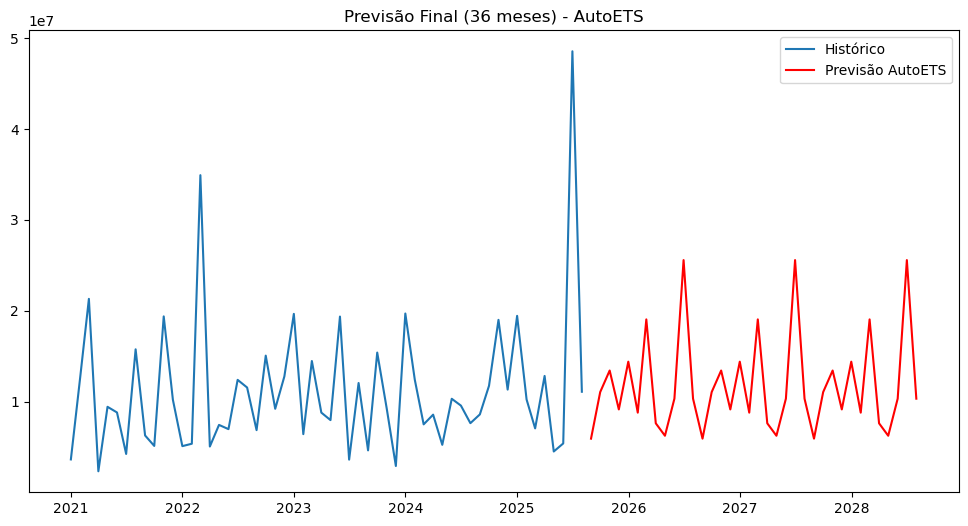

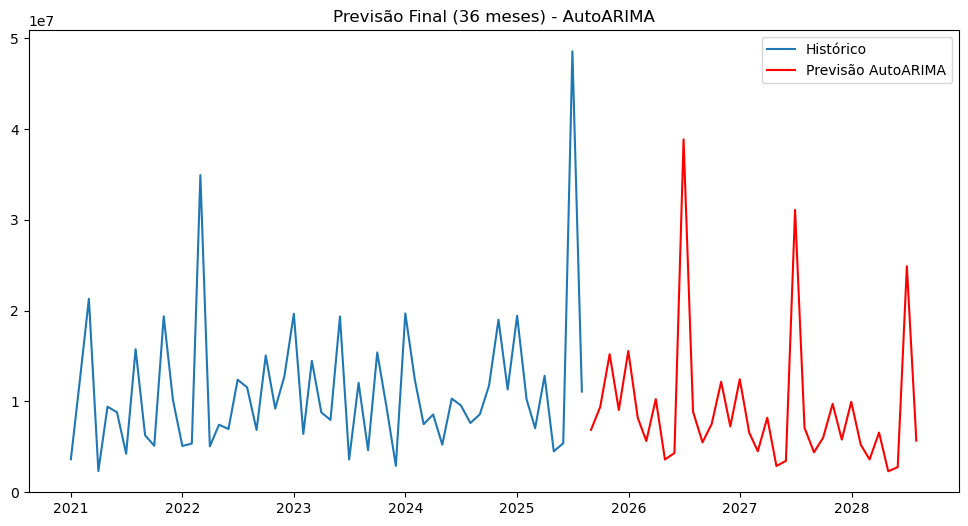

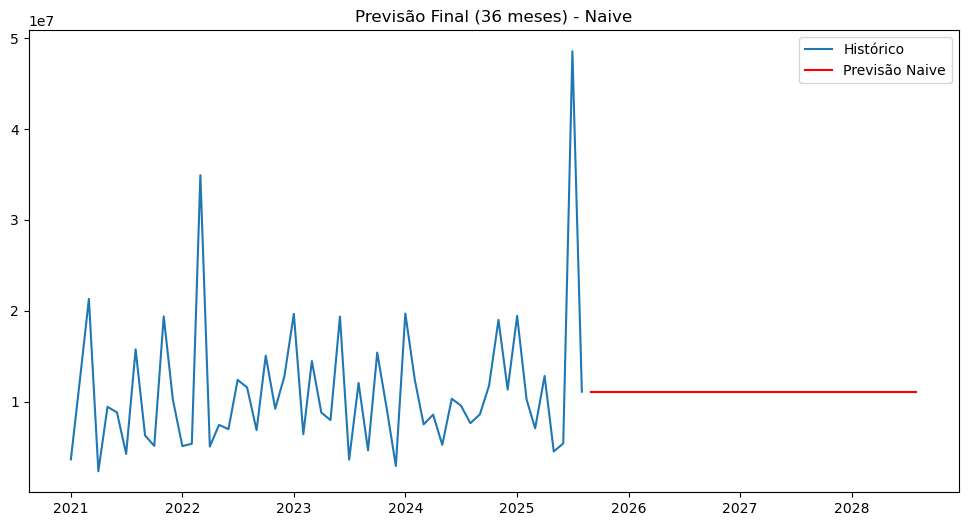

In [15]:
# 9. Gráficos

# Backtest StatsForecast (continua 12 meses, pois só serve para avaliação histórica)
plt.figure(figsize=(12,6))
plt.plot(cv_results['ds'], cv_results['y'], label='Real', color='black')
for model in models_to_eval:
    plt.plot(cv_results['ds'], cv_results[model], label=model, alpha=0.7)
plt.legend()
plt.title("Backtest - Modelos StatsForecast (12 meses)")
plt.show()

# Previsão final 36 meses para ML (RF e XGB)
plt.figure(figsize=(12,6))
plt.plot(df_grouped['ds'], df_grouped['y'], label="Histórico", color="black", linewidth=2)
plt.plot(forecast_rf['ds'], forecast_rf['RandomForest'], label="Random Forest (36m)", marker="o")
plt.plot(forecast_xgb['ds'], forecast_xgb['XGBoost'], label="XGBoost (36m)", marker="x")
plt.legend()
plt.title("Previsão Final - Random Forest e XGBoost (36 meses)")
plt.show()

# Previsão final 36 meses para cada modelo do StatsForecast
for model in models_to_eval:
    plt.figure(figsize=(12,6))
    plt.plot(df_grouped['ds'], df_grouped['y'], label="Histórico")
    plt.plot(forecast_36['ds'], forecast_36[model], label=f"Previsão {model}", color="red")
    plt.legend()
    plt.title(f"Previsão Final (36 meses) - {model}")
    plt.show()



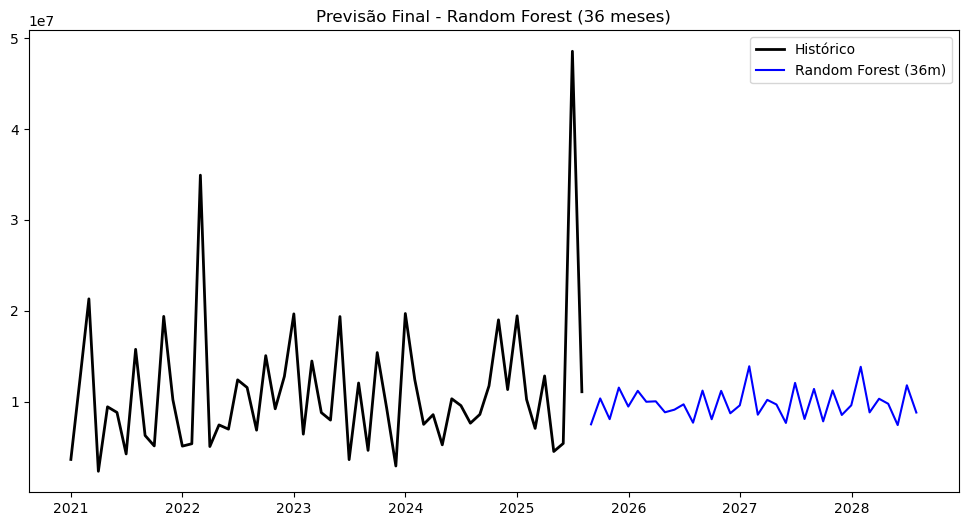

In [21]:
# 9. Gráficos - Separados e Todos Juntos

# 1. Previsão final 36 meses - Random Forest
plt.figure(figsize=(12,6))
plt.plot(df_grouped['ds'], df_grouped['y'], label="Histórico", color="black", linewidth=2)
plt.plot(forecast_rf['ds'], forecast_rf['RandomForest'], label="Random Forest (36m)", color="blue")
plt.legend()
plt.title("Previsão Final - Random Forest (36 meses)")
plt.show()




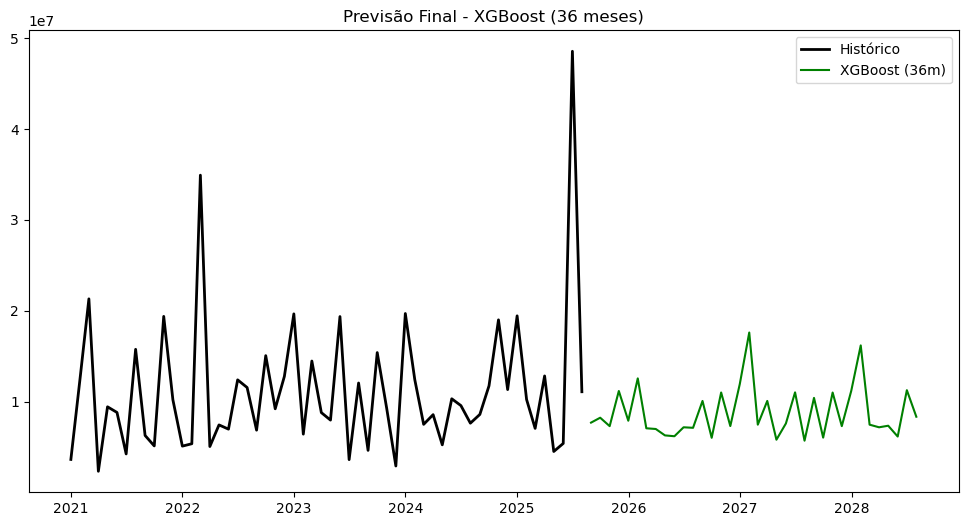

In [16]:
# 2. Previsão final 36 meses - XGBoost
plt.figure(figsize=(12,6))
plt.plot(df_grouped['ds'], df_grouped['y'], label="Histórico", color="black", linewidth=2)
plt.plot(forecast_xgb['ds'], forecast_xgb['XGBoost'], label="XGBoost (36m)", color="green")
plt.legend()
plt.title("Previsão Final - XGBoost (36 meses)")
plt.show()

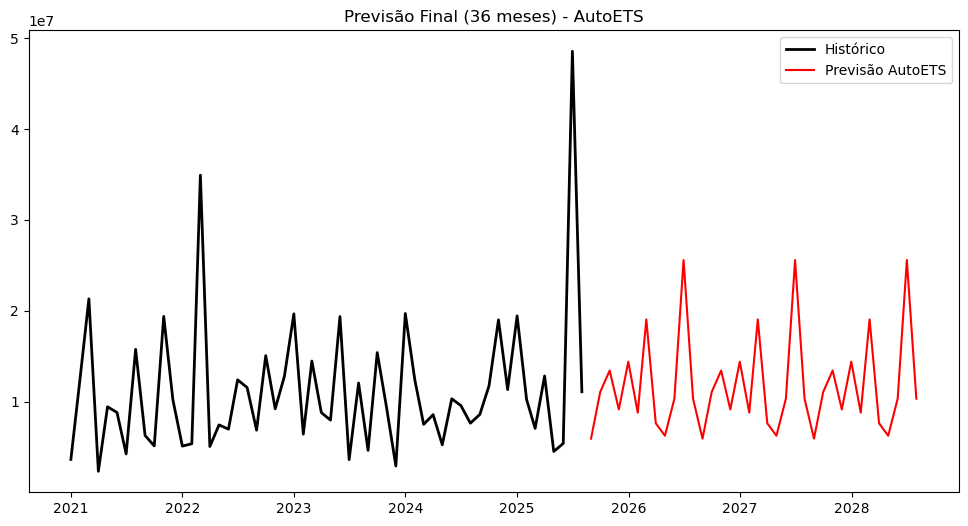

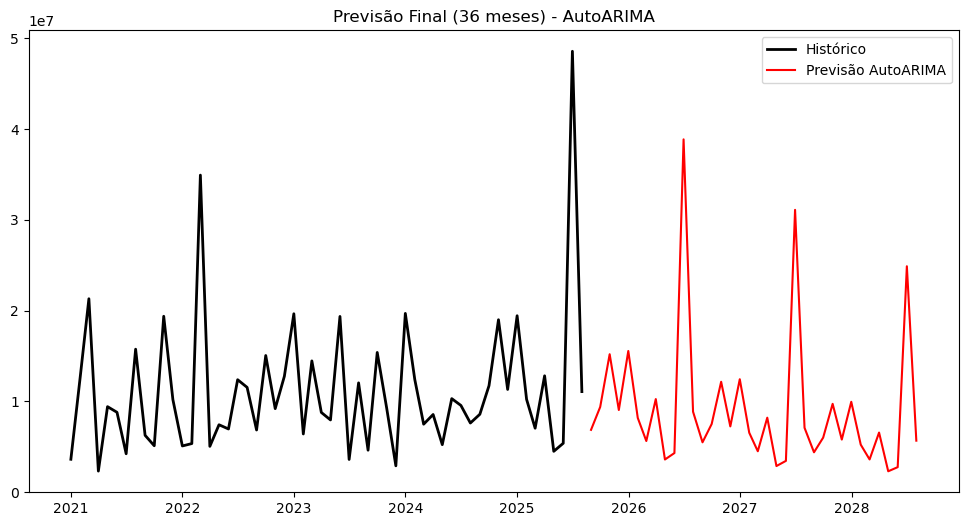

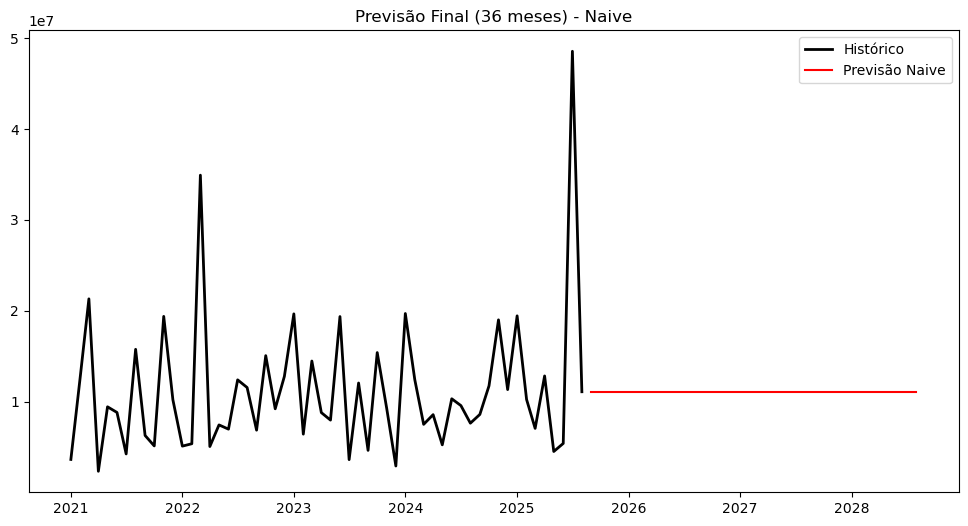

In [17]:
# 3. Previsão final 36 meses - StatsForecast
for model in models_to_eval:
    plt.figure(figsize=(12,6))
    plt.plot(df_grouped['ds'], df_grouped['y'], label="Histórico", color="black", linewidth=2)
    plt.plot(forecast_36['ds'], forecast_36[model], label=f"Previsão {model}", color="red")
    plt.legend()
    plt.title(f"Previsão Final (36 meses) - {model}")
    plt.show()

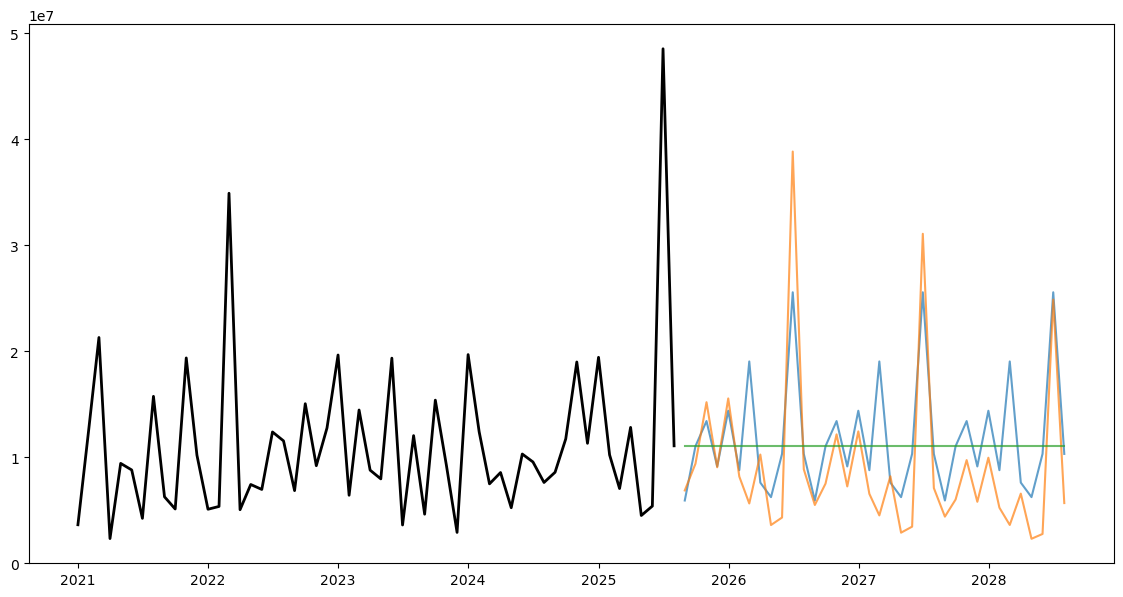

In [18]:
# 4. Todos os modelos juntos
plt.figure(figsize=(14,7))
plt.plot(df_grouped['ds'], df_grouped['y'], label="Histórico", color="black", linewidth=2)

# StatsForecast
for model in models_to_eval:
    plt.plot(forecast_36['ds'], forecast_36[model], label=model, alpha=0.7)

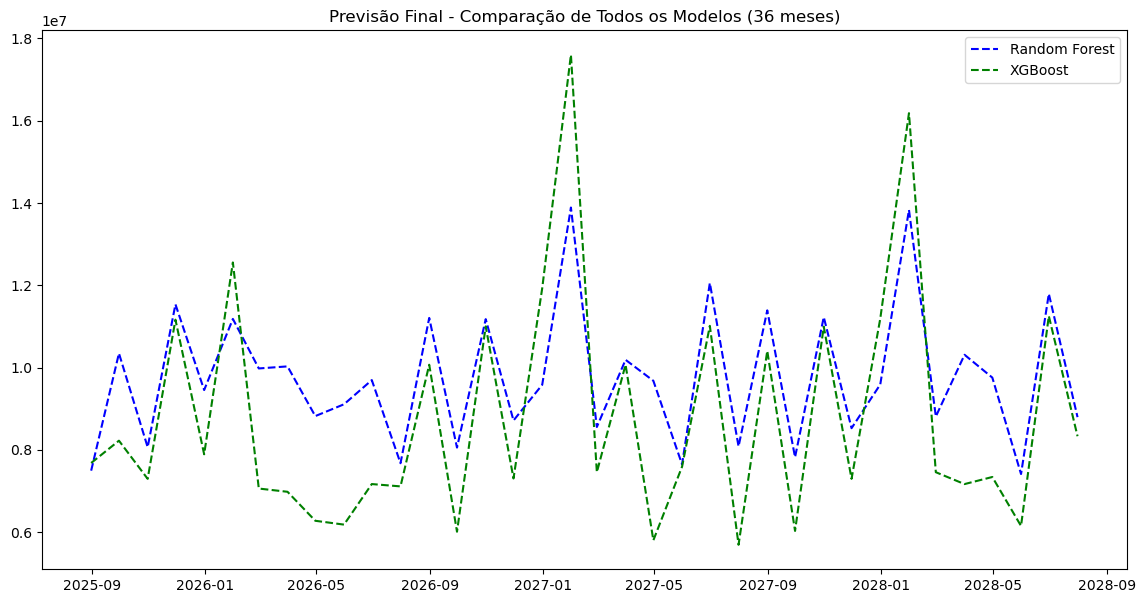

In [20]:
# RF e XGB
plt.figure(figsize=(14,7))
plt.plot(forecast_rf['ds'], forecast_rf['RandomForest'], label="Random Forest", color="blue", linestyle="--")
plt.plot(forecast_xgb['ds'], forecast_xgb['XGBoost'], label="XGBoost", color="green", linestyle="--")

plt.legend()
plt.title("Previsão Final - Comparação de Todos os Modelos (36 meses)")
plt.show()

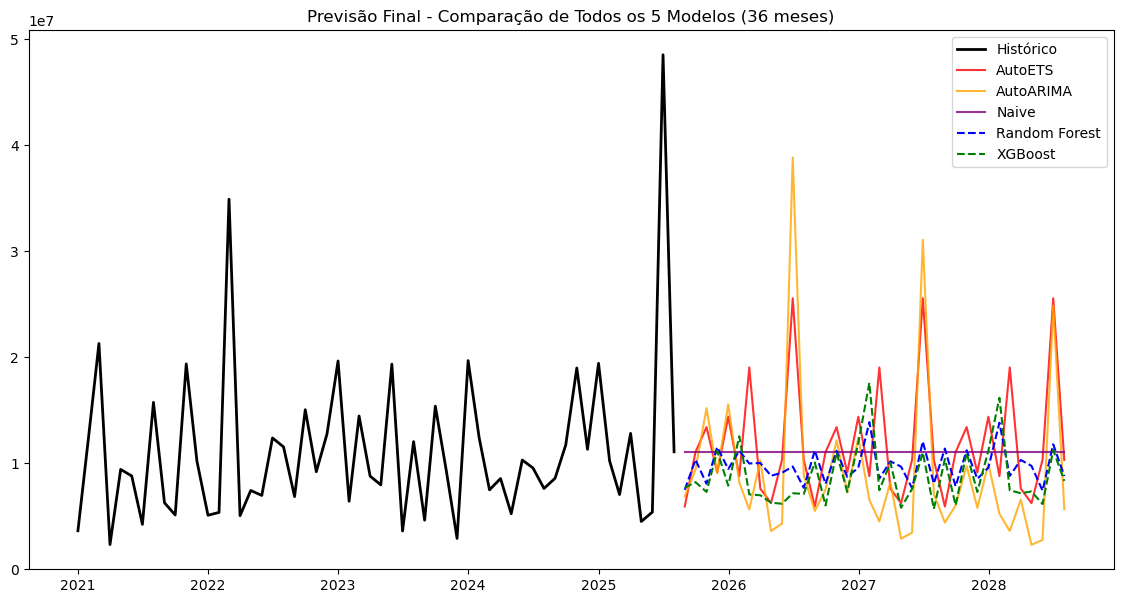

In [23]:
# Gráfico final com TODOS os 5 modelos (36 meses)

plt.figure(figsize=(14,7))
plt.plot(df_grouped['ds'], df_grouped['y'], label="Histórico", color="black", linewidth=2)

# StatsForecast (3 modelos)
plt.plot(forecast_36['ds'], forecast_36['AutoETS'], label="AutoETS", alpha=0.8, color="red")
plt.plot(forecast_36['ds'], forecast_36['AutoARIMA'], label="AutoARIMA", alpha=0.8, color="orange")
plt.plot(forecast_36['ds'], forecast_36['Naive'], label="Naive", alpha=0.8, color="purple")

# Machine Learning (RF e XGB)
plt.plot(forecast_rf['ds'], forecast_rf['RandomForest'], label="Random Forest", linestyle="--", color="blue")
plt.plot(forecast_xgb['ds'], forecast_xgb['XGBoost'], label="XGBoost", linestyle="--", color="green")

plt.legend()
plt.title("Previsão Final - Comparação de Todos os 5 Modelos (36 meses)")
plt.show()


In [28]:
# Exemplo com AutoETS
forecast_36['AutoETS_var_pct'] = forecast_36['AutoETS'].pct_change() * 100

print(forecast_36[['ds', 'AutoETS', 'AutoETS_var_pct']].head(15))


                  ds     AutoETS  AutoETS_var_pct
unique_id                                        
serie1    2025-08-31   5921025.5              NaN
serie1    2025-09-30  11045042.0        86.539337
serie1    2025-10-31  13418504.0        21.488941
serie1    2025-11-30   9136039.0       -31.914621
serie1    2025-12-31  14394217.0        57.554245
serie1    2026-01-31   8784345.0       -38.973091
serie1    2026-02-28  19045126.0       116.807579
serie1    2026-03-31   7609997.5       -60.042286
serie1    2026-04-30   6240851.0       -17.991417
serie1    2026-05-31  10325370.0        65.448105
serie1    2026-06-30  25572960.0       147.671127
serie1    2026-07-31  10319012.0       -59.648739
serie1    2026-08-31   5921025.5       -42.620232
serie1    2026-09-30  11045042.0        86.539337
serie1    2026-10-31  13418504.0        21.488941


In [29]:
forecast_36['AutoETS_var_acumulada'] = (
    (forecast_36['AutoETS'] / forecast_36['AutoETS'].iloc[0] - 1) * 100
)

print(forecast_36[['ds', 'AutoETS', 'AutoETS_var_acumulada']].head(15))



                  ds     AutoETS  AutoETS_var_acumulada
unique_id                                              
serie1    2025-08-31   5921025.5               0.000000
serie1    2025-09-30  11045042.0              86.539337
serie1    2025-10-31  13418504.0             126.624657
serie1    2025-11-30   9136039.0              54.298256
serie1    2025-12-31  14394217.0             143.103455
serie1    2026-01-31   8784345.0              48.358513
serie1    2026-02-28  19045126.0             221.652481
serie1    2026-03-31   7609997.5              28.524994
serie1    2026-04-30   6240851.0               5.401528
serie1    2026-05-31  10325370.0              74.384819
serie1    2026-06-30  25572960.0             331.900879
serie1    2026-07-31  10319012.0              74.277451
serie1    2026-08-31   5921025.5               0.000000
serie1    2026-09-30  11045042.0              86.539337
serie1    2026-10-31  13418504.0             126.624657


In [31]:
for col in ['AutoETS', 'AutoARIMA', 'Naive']:
    forecast_36[f'{col}_var_pct'] = forecast_36[col].pct_change() * 100
    forecast_36[f'{col}_var_acumulada'] = (
        (forecast_36[col] / forecast_36[col].iloc[0] - 1) * 100
    )

forecast_rf['RandomForest_var_pct'] = forecast_rf['RandomForest'].pct_change() * 100
forecast_xgb['XGBoost_var_pct'] = forecast_xgb['XGBoost'].pct_change() * 100


In [32]:
# Criar DataFrame de comparação (últimos 12 meses)
df_compare_ml = pd.DataFrame({
    "ds": df_ml['ds'][-12:].values,
    "y_real": y_test.values,
    "RandomForest": y_pred_rf,
    "XGBoost": y_pred_xgb
})

print(df_compare_ml)


           ds       y_real  RandomForest     XGBoost
0  2024-09-01   8586798.77  1.225862e+07  11203170.0
1  2024-10-01  11737218.57  8.487332e+06   8291090.5
2  2024-11-01  18995003.61  8.568550e+06   9868616.0
3  2024-12-01  11320140.88  8.071245e+06   9826616.0
4  2025-01-01  19435267.28  1.246611e+07  13711201.0
5  2025-02-01  10229335.71  8.522611e+06   7153641.5
6  2025-03-01   7051087.19  1.020492e+07   7272647.5
7  2025-04-01  12822154.67  1.044726e+07   8601288.0
8  2025-05-01   4507081.27  9.330522e+06   8467159.0
9  2025-06-01   5393964.04  1.161571e+07   9983481.0
10 2025-07-01  48554186.16  2.005117e+07  12609724.0
11 2025-08-01  11082437.71  5.849314e+06   7096654.0


In [33]:
# Selecionar só a janela dos últimos 12 meses em cv_results
df_compare_sf = cv_results[['ds','y','AutoETS','AutoARIMA','Naive']].dropna().tail(12)

# Juntar RF e XGB
df_compare_all = df_compare_sf.merge(df_compare_ml, on="ds", how="inner")

print(df_compare_all)


           ds           y     AutoETS    AutoARIMA      Naive       y_real  \
0  2024-09-01   8586799.0  10397325.0   3701041.00  7623799.5   8586798.77   
1  2024-10-01  11737219.0  10397325.0  12304218.00  7623799.5  11737218.57   
2  2024-11-01  18995004.0  10397325.0   7399870.00  7623799.5  18995003.61   
3  2024-12-01  11320141.0  10397325.0   2325740.75  7623799.5  11320140.88   
4  2025-01-01  19435268.0  10397325.0  15740378.00  7623799.5  19435267.28   
5  2025-02-01  10229336.0  10397325.0   9917183.00  7623799.5  10229335.71   
6  2025-03-01   7051087.0  10397325.0   5989843.50  7623799.5   7051087.19   
7  2025-04-01  12822155.0  10397325.0   6843475.00  7623799.5  12822154.67   
8  2025-05-01   4507081.5  10397325.0   4188812.25  7623799.5   4507081.27   
9  2025-06-01   5393964.0  10397325.0   8239459.00  7623799.5   5393964.04   
10 2025-07-01  48554188.0  10397325.0   7640247.50  7623799.5  48554186.16   
11 2025-08-01  11082438.0  10397325.0   6093797.00  7623799.5  1

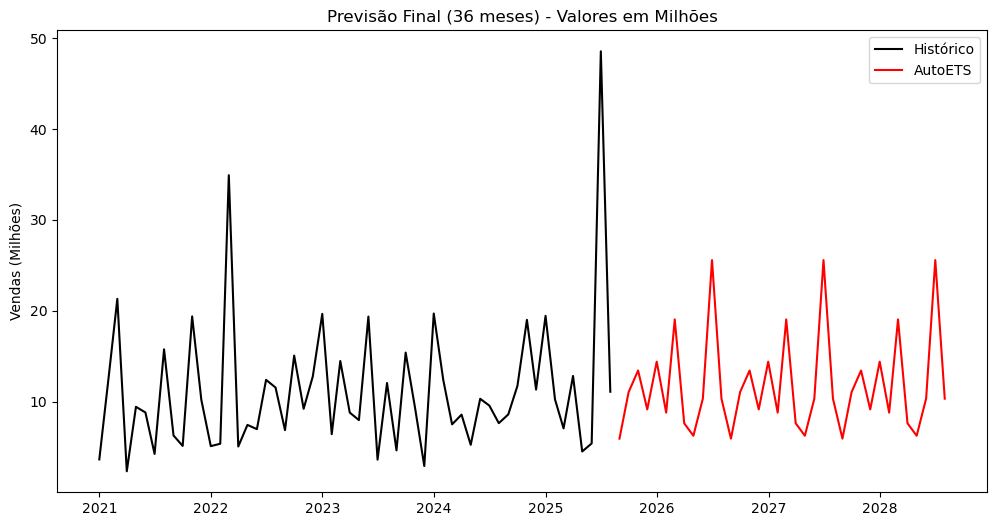

In [34]:
plt.figure(figsize=(12,6))
plt.plot(df_grouped['ds'], df_grouped['y']/1e6, label="Histórico", color="black")
plt.plot(forecast_36['ds'], forecast_36['AutoETS']/1e6, label="AutoETS", color="red")

plt.legend()
plt.title("Previsão Final (36 meses) - Valores em Milhões")
plt.ylabel("Vendas (Milhões)")
plt.show()
